In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
# import keras_metrics as km

# 第一步：构建训练数据
# 1.1 导入数据
train_image_path = glob.glob('./test/dataset_LUSC_correct/*/*.png') # 已经将数据放在的代码的文件夹中。
train_image_label = [int(path.split('\\')[1]=='yang') for path in train_image_path]  # 使用列表表达式。根据路径的特点，得出每个路径的图片对应的标签

# 1.2 定义加载预处理数据的函数
def load_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels = 3)
    # image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image / 255 
    label = tf.reshape(label, [1])   # 将标签 从一维 变成 二维。 [1 , 1, 0 , 1] -> [[1], [1], [0], [1]]
    return image, label
def load_preprocess_val_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels = 3)
    # image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label
# 1.3 使用路径和标签,创建数据集
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_image_ds = train_image_ds.map(load_preprocess_image, num=AUTOTUNE)  # AUTOTUNE 自动根据CPU进行并行运算
train_image_ds = train_image_ds.map(load_preprocess_image, num_parallel_calls = AUTOTUNE)


# 1.4 再对训练数据做一些处理
BATCH_SIZE = 16
train_count = len(train_image_path)
train_image_ds = train_image_ds.shuffle(train_count).batch(BATCH_SIZE)

# 第二步： 构建测试数据

val_image_path = glob.glob('./test/dataset_LUSC_correct_test/*/*.png')
val_image_label = [int(path.split('\\')[1] == 'yang') for path in val_image_path]

val_image_ds = tf.data.Dataset.from_tensor_slices((val_image_path, val_image_label))
val_image_ds = val_image_ds.map(load_preprocess_val_image, num_parallel_calls = AUTOTUNE )
val_image_ds = val_image_ds.repeat().batch(BATCH_SIZE)

val_count = len(val_image_path)

In [2]:
# 第三步： keras内置的Xception网络的实现：
covn_base = keras.applications.xception.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (80, 80, 3),
    pooling = 'avg'
)
covn_base.trainable = False
# covn_base.summary()
# 3.2 建立model
model = keras.Sequential()
model.add(covn_base)
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
# 3.3 model 编译
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate = 0.0005),
    loss = 'binary_crossentropy',
    # metrics = ['accuracy',km.f1_score(), km.binary_precision(), km.binary_recall()]
    metrics = ['accuracy']
)


In [3]:
initial_epochs = 5
# 3.4 model 的训练
history  = model.fit(
    train_image_ds,
    # steps_per_epoch = int(train_count / BATCH_SIZE)
    steps_per_epoch = 50,
    epochs = initial_epochs,
    validation_data = val_image_ds,
    # validation_steps =  int(val_count / BATCH_SIZE)
    validation_steps = 10
)


Epoch 1/5
50/50 [==============================] - 10s 57ms/step - loss: 0.4688 - accuracy: 0.7588 - val_loss: 0.4607 - val_accuracy: 0.8687
Epoch 2/5
50/50 [==============================] - 2s 44ms/step - loss: 0.4302 - accuracy: 0.8388 - val_loss: 0.8030 - val_accuracy: 0.5938
Epoch 3/5
50/50 [==============================] - 2s 45ms/step - loss: 0.4241 - accuracy: 0.8300 - val_loss: 0.7584 - val_accuracy: 0.5500
Epoch 4/5
50/50 [==============================] - 2s 46ms/step - loss: 0.4217 - accuracy: 0.8188 - val_loss: 0.6790 - val_accuracy: 0.6625
Epoch 5/5
50/50 [==============================] - 2s 46ms/step - loss: 0.3627 - accuracy: 0.8550 - val_loss: 0.6104 - val_accuracy: 0.7063


In [4]:
# 第4步：微调
# 4.1 解冻
covn_base.trainable = True  
# len(covn_base.layers)   # 133
# 4.2 打开部分层，关闭前面的层
fine_tune_at = -33
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable= False
# 4.3 编译
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0005 /10),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# 4.4 准备参数，开始训练
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history = model.fit(
    train_image_ds,
    steps_per_epoch = 50,
    epochs = total_epochs,
    initial_epoch = initial_epochs,
    validation_data = val_image_ds,
    validation_steps = 10
)

model.save("test/my_model.h5")

Epoch 6/15
50/50 [==============================] - 10s 84ms/step - loss: 0.6045 - accuracy: 0.6875 - val_loss: 0.8006 - val_accuracy: 0.5875
Epoch 7/15
50/50 [==============================] - 4s 70ms/step - loss: 0.4609 - accuracy: 0.7850 - val_loss: 0.3174 - val_accuracy: 0.8875
Epoch 8/15
50/50 [==============================] - 4s 72ms/step - loss: 0.3427 - accuracy: 0.8675 - val_loss: 0.2354 - val_accuracy: 0.8875
Epoch 9/15
50/50 [==============================] - 4s 72ms/step - loss: 0.3488 - accuracy: 0.8462 - val_loss: 0.2547 - val_accuracy: 0.9062
Epoch 10/15
50/50 [==============================] - 4s 73ms/step - loss: 0.3127 - accuracy: 0.8487 - val_loss: 0.1591 - val_accuracy: 0.9312
Epoch 11/15
50/50 [==============================] - 4s 73ms/step - loss: 0.3429 - accuracy: 0.8537 - val_loss: 0.3010 - val_accuracy: 0.8562
Epoch 12/15
50/50 [==============================] - 4s 73ms/step - loss: 0.3104 - accuracy: 0.8700 - val_loss: 0.2611 - val_accuracy: 0.9187
Epoch 13/

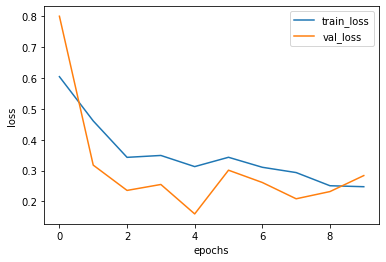

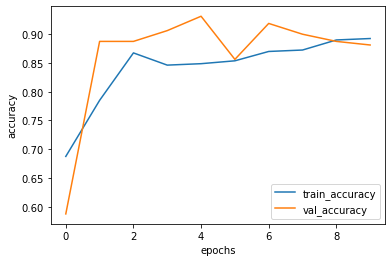

In [5]:
# plot loss and accuracy image
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# figure 1
plt.figure()
plt.plot(range(10), train_loss, label='train_loss')
plt.plot(range(10), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# figure 2
plt.figure()
plt.plot(range(10), train_accuracy, label='train_accuracy')
plt.plot(range(10), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()